In [1]:
import logging

import probtorch
import torch

import combinators
import foldable
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_step = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=ssm_initializer)
ssm_sequence = foldable.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1))

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.hyper_population(combinators.PrimitiveCall(ssm.init_ssm), particle_shape, hyper=ssm_params)
ssm_step_generative = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=init_ssm_generative)
ssm_generative = foldable.Reduce(ssm_step_generative, lambda: range(50))

In [10]:
init_ssm_proposal = combinators.hyper_population(combinators.PrimitiveCall(ssm.init_ssm), particle_shape, trainable=ssm_params)
ssm_step_proposal = foldable.Foldable(combinators.PrimitiveCall(ssm.ssm_step), initializer=init_ssm_proposal)
ssm_proposal = foldable.Reduce(ssm_step_proposal, lambda: range(50))

In [11]:
ssm_training = combinators.score_under_proposal(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_training, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

01/17/2019 16:31:23 ELBO=-2.02147644e+02 at epoch 1
01/17/2019 16:31:23 ELBO=-3.90174591e+02 at epoch 2
01/17/2019 16:31:23 ELBO=-2.49868073e+02 at epoch 3
01/17/2019 16:31:23 ELBO=-3.57783356e+02 at epoch 4
01/17/2019 16:31:23 ELBO=-4.22697266e+02 at epoch 5
01/17/2019 16:31:23 ELBO=-2.31164734e+02 at epoch 6
01/17/2019 16:31:23 ELBO=-3.37997253e+02 at epoch 7
01/17/2019 16:31:23 ELBO=-3.67283844e+02 at epoch 8
01/17/2019 16:31:23 ELBO=-2.82757782e+02 at epoch 9
01/17/2019 16:31:24 ELBO=-2.97773468e+02 at epoch 10
01/17/2019 16:31:24 ELBO=-4.79507355e+02 at epoch 11
01/17/2019 16:31:24 ELBO=-4.61045441e+02 at epoch 12
01/17/2019 16:31:24 ELBO=-2.67891754e+02 at epoch 13
01/17/2019 16:31:24 ELBO=-2.50360413e+02 at epoch 14
01/17/2019 16:31:24 ELBO=-2.29382568e+02 at epoch 15
01/17/2019 16:31:24 ELBO=-5.29663879e+02 at epoch 16
01/17/2019 16:31:24 ELBO=-4.35574005e+02 at epoch 17
01/17/2019 16:31:24 ELBO=-8.80375183e+02 at epoch 18
01/17/2019 16:31:24 ELBO=-7.56310120e+02 at epoch 19
01

Epoch   299: reducing learning rate of group 0 to 5.0000e-03.


01/17/2019 16:31:43 ELBO=-4.13213562e+02 at epoch 303
01/17/2019 16:31:43 ELBO=-2.32002686e+02 at epoch 304
01/17/2019 16:31:44 ELBO=-3.25472290e+02 at epoch 305
01/17/2019 16:31:44 ELBO=-3.05560608e+02 at epoch 306
01/17/2019 16:31:44 ELBO=-3.60871613e+02 at epoch 307
01/17/2019 16:31:44 ELBO=-2.63463257e+02 at epoch 308
01/17/2019 16:31:44 ELBO=-3.92404755e+02 at epoch 309
01/17/2019 16:31:44 ELBO=-2.92911743e+02 at epoch 310
01/17/2019 16:31:44 ELBO=-3.13236969e+02 at epoch 311
01/17/2019 16:31:44 ELBO=-4.03758850e+02 at epoch 312
01/17/2019 16:31:44 ELBO=-2.71619293e+02 at epoch 313
01/17/2019 16:31:44 ELBO=-2.07594940e+02 at epoch 314
01/17/2019 16:31:44 ELBO=-2.29022308e+02 at epoch 315
01/17/2019 16:31:44 ELBO=-7.08357117e+02 at epoch 316
01/17/2019 16:31:44 ELBO=-3.25161072e+02 at epoch 317
01/17/2019 16:31:44 ELBO=-2.62134888e+02 at epoch 318
01/17/2019 16:31:44 ELBO=-2.96973755e+02 at epoch 319
01/17/2019 16:31:44 ELBO=-3.84361328e+02 at epoch 320
01/17/2019 16:31:45 ELBO=-3.

Epoch   400: reducing learning rate of group 0 to 2.5000e-03.


01/17/2019 16:31:50 ELBO=-3.12681213e+02 at epoch 405
01/17/2019 16:31:50 ELBO=-3.01440948e+02 at epoch 406
01/17/2019 16:31:50 ELBO=-2.83835876e+02 at epoch 407
01/17/2019 16:31:50 ELBO=-3.28288544e+02 at epoch 408
01/17/2019 16:31:50 ELBO=-3.88068024e+02 at epoch 409
01/17/2019 16:31:50 ELBO=-2.09015015e+02 at epoch 410
01/17/2019 16:31:50 ELBO=-2.67397308e+02 at epoch 411
01/17/2019 16:31:50 ELBO=-3.16696564e+02 at epoch 412
01/17/2019 16:31:50 ELBO=-2.12593933e+02 at epoch 413
01/17/2019 16:31:50 ELBO=-2.29347244e+02 at epoch 414
01/17/2019 16:31:51 ELBO=-2.39582550e+02 at epoch 415
01/17/2019 16:31:51 ELBO=-2.59028076e+02 at epoch 416
01/17/2019 16:31:51 ELBO=-2.05899506e+02 at epoch 417
01/17/2019 16:31:51 ELBO=-3.76921997e+02 at epoch 418
01/17/2019 16:31:51 ELBO=-3.59795074e+02 at epoch 419
01/17/2019 16:31:51 ELBO=-2.07520920e+02 at epoch 420
01/17/2019 16:31:51 ELBO=-4.12265930e+02 at epoch 421
01/17/2019 16:31:51 ELBO=-3.15300201e+02 at epoch 422
01/17/2019 16:31:51 ELBO=-3.

Epoch   501: reducing learning rate of group 0 to 1.2500e-03.


01/17/2019 16:31:56 ELBO=-2.50418549e+02 at epoch 505
01/17/2019 16:31:56 ELBO=-5.44731445e+02 at epoch 506
01/17/2019 16:31:57 ELBO=-4.07476593e+02 at epoch 507
01/17/2019 16:31:57 ELBO=-2.49744308e+02 at epoch 508
01/17/2019 16:31:57 ELBO=-1.79012024e+02 at epoch 509
01/17/2019 16:31:57 ELBO=-2.43325226e+02 at epoch 510
01/17/2019 16:31:57 ELBO=-2.56971802e+02 at epoch 511
01/17/2019 16:31:57 ELBO=-8.84103333e+02 at epoch 512
01/17/2019 16:31:57 ELBO=-2.20102600e+02 at epoch 513
01/17/2019 16:31:57 ELBO=-5.20783752e+02 at epoch 514
01/17/2019 16:31:57 ELBO=-2.34360229e+02 at epoch 515
01/17/2019 16:31:57 ELBO=-4.83314545e+02 at epoch 516
01/17/2019 16:31:57 ELBO=-2.60591370e+02 at epoch 517
01/17/2019 16:31:57 ELBO=-3.36988037e+02 at epoch 518
01/17/2019 16:31:57 ELBO=-3.35663391e+02 at epoch 519
01/17/2019 16:31:57 ELBO=-2.93197296e+02 at epoch 520
01/17/2019 16:31:57 ELBO=-2.88709015e+02 at epoch 521
01/17/2019 16:31:57 ELBO=-2.75685059e+02 at epoch 522
01/17/2019 16:31:57 ELBO=-2.

Epoch   602: reducing learning rate of group 0 to 6.2500e-04.


01/17/2019 16:32:03 ELBO=-2.88388092e+02 at epoch 607
01/17/2019 16:32:03 ELBO=-2.40971161e+02 at epoch 608
01/17/2019 16:32:03 ELBO=-2.50316498e+02 at epoch 609
01/17/2019 16:32:03 ELBO=-2.96350708e+02 at epoch 610
01/17/2019 16:32:03 ELBO=-3.41108978e+02 at epoch 611
01/17/2019 16:32:03 ELBO=-3.45131958e+02 at epoch 612
01/17/2019 16:32:03 ELBO=-3.58689392e+02 at epoch 613
01/17/2019 16:32:03 ELBO=-2.23537674e+02 at epoch 614
01/17/2019 16:32:03 ELBO=-3.13904877e+02 at epoch 615
01/17/2019 16:32:03 ELBO=-3.68660614e+02 at epoch 616
01/17/2019 16:32:03 ELBO=-2.35026459e+02 at epoch 617
01/17/2019 16:32:04 ELBO=-3.74407410e+02 at epoch 618
01/17/2019 16:32:04 ELBO=-2.24841949e+02 at epoch 619
01/17/2019 16:32:04 ELBO=-3.49399261e+02 at epoch 620
01/17/2019 16:32:04 ELBO=-3.10574646e+02 at epoch 621
01/17/2019 16:32:04 ELBO=-2.55592239e+02 at epoch 622
01/17/2019 16:32:04 ELBO=-3.35262238e+02 at epoch 623
01/17/2019 16:32:04 ELBO=-2.83588135e+02 at epoch 624
01/17/2019 16:32:04 ELBO=-2.

Epoch   706: reducing learning rate of group 0 to 3.1250e-04.


01/17/2019 16:32:10 ELBO=-1.93825256e+02 at epoch 710
01/17/2019 16:32:10 ELBO=-4.17207764e+02 at epoch 711
01/17/2019 16:32:10 ELBO=-3.17218994e+02 at epoch 712
01/17/2019 16:32:10 ELBO=-4.60674469e+02 at epoch 713
01/17/2019 16:32:10 ELBO=-1.92232040e+02 at epoch 714
01/17/2019 16:32:10 ELBO=-3.17396576e+02 at epoch 715
01/17/2019 16:32:10 ELBO=-2.85573334e+02 at epoch 716
01/17/2019 16:32:10 ELBO=-2.56838867e+02 at epoch 717
01/17/2019 16:32:11 ELBO=-3.02975708e+02 at epoch 718
01/17/2019 16:32:11 ELBO=-3.28759460e+02 at epoch 719
01/17/2019 16:32:11 ELBO=-2.42563660e+02 at epoch 720
01/17/2019 16:32:11 ELBO=-3.52327667e+02 at epoch 721
01/17/2019 16:32:11 ELBO=-2.27936798e+02 at epoch 722
01/17/2019 16:32:11 ELBO=-2.40272064e+02 at epoch 723
01/17/2019 16:32:11 ELBO=-5.69438599e+02 at epoch 724
01/17/2019 16:32:11 ELBO=-2.44595825e+02 at epoch 725
01/17/2019 16:32:11 ELBO=-2.63359680e+02 at epoch 726
01/17/2019 16:32:11 ELBO=-2.48785446e+02 at epoch 727
01/17/2019 16:32:11 ELBO=-3.

Epoch   867: reducing learning rate of group 0 to 1.5625e-04.


01/17/2019 16:32:21 ELBO=-3.66708374e+02 at epoch 872
01/17/2019 16:32:21 ELBO=-3.26301178e+02 at epoch 873
01/17/2019 16:32:21 ELBO=-3.98933228e+02 at epoch 874
01/17/2019 16:32:21 ELBO=-3.97302185e+02 at epoch 875
01/17/2019 16:32:21 ELBO=-4.56957062e+02 at epoch 876
01/17/2019 16:32:21 ELBO=-3.85970459e+02 at epoch 877
01/17/2019 16:32:21 ELBO=-2.49433136e+02 at epoch 878
01/17/2019 16:32:21 ELBO=-2.67416321e+02 at epoch 879
01/17/2019 16:32:21 ELBO=-3.78848450e+02 at epoch 880
01/17/2019 16:32:21 ELBO=-3.10097107e+02 at epoch 881
01/17/2019 16:32:21 ELBO=-4.38331512e+02 at epoch 882
01/17/2019 16:32:21 ELBO=-3.16195984e+02 at epoch 883
01/17/2019 16:32:22 ELBO=-2.34493652e+02 at epoch 884
01/17/2019 16:32:22 ELBO=-2.09196899e+02 at epoch 885
01/17/2019 16:32:22 ELBO=-2.54383774e+02 at epoch 886
01/17/2019 16:32:22 ELBO=-5.33906860e+02 at epoch 887
01/17/2019 16:32:22 ELBO=-3.12789673e+02 at epoch 888
01/17/2019 16:32:22 ELBO=-2.76063446e+02 at epoch 889
01/17/2019 16:32:22 ELBO=-4.

Epoch   968: reducing learning rate of group 0 to 7.8125e-05.


01/17/2019 16:32:27 ELBO=-2.76204407e+02 at epoch 973
01/17/2019 16:32:27 ELBO=-2.51998016e+02 at epoch 974
01/17/2019 16:32:27 ELBO=-2.80685547e+02 at epoch 975
01/17/2019 16:32:27 ELBO=-3.42326019e+02 at epoch 976
01/17/2019 16:32:28 ELBO=-3.38996124e+02 at epoch 977
01/17/2019 16:32:28 ELBO=-5.04279999e+02 at epoch 978
01/17/2019 16:32:28 ELBO=-3.44500000e+02 at epoch 979
01/17/2019 16:32:28 ELBO=-2.23391235e+02 at epoch 980
01/17/2019 16:32:28 ELBO=-3.23760040e+02 at epoch 981
01/17/2019 16:32:28 ELBO=-3.00806427e+02 at epoch 982
01/17/2019 16:32:28 ELBO=-2.47993820e+02 at epoch 983
01/17/2019 16:32:28 ELBO=-2.14133270e+02 at epoch 984
01/17/2019 16:32:28 ELBO=-3.30566223e+02 at epoch 985
01/17/2019 16:32:28 ELBO=-3.72868683e+02 at epoch 986
01/17/2019 16:32:28 ELBO=-3.30036987e+02 at epoch 987
01/17/2019 16:32:28 ELBO=-4.54118408e+02 at epoch 988
01/17/2019 16:32:28 ELBO=-4.15763214e+02 at epoch 989
01/17/2019 16:32:28 ELBO=-2.47057220e+02 at epoch 990
01/17/2019 16:32:28 ELBO=-3.

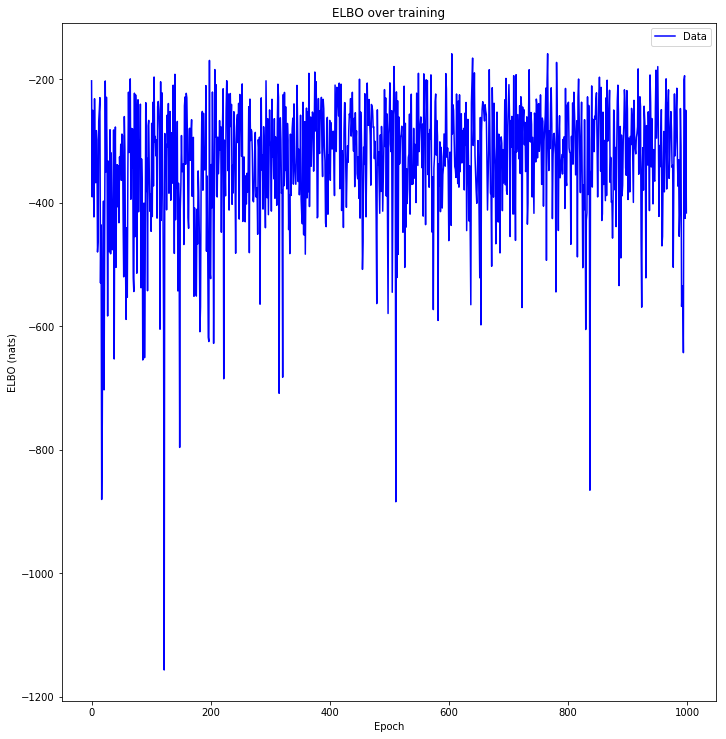

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
ssm_smc = mcmc.reduce_resample_move_smc(combinators.PrimitiveCall(ssm.ssm_step), particle_shape, lambda: range(50), initializer=init_ssm_proposal, moves=10)
ssm_score = combinators.score_under_proposal(ssm_smc, ssm_generative)

In [15]:
_, inference = ssm_score(data=data)

In [16]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 1.389212
SMC MSE at time 2: 0.074478
SMC MSE at time 3: 0.041547
SMC MSE at time 4: 0.193432
SMC MSE at time 5: 1.568871
SMC MSE at time 6: 0.450185
SMC MSE at time 7: 0.488858
SMC MSE at time 8: 5.232995
SMC MSE at time 9: 11.560438
SMC MSE at time 10: 10.340341
SMC MSE at time 11: 3.818105
SMC MSE at time 12: 3.586028
SMC MSE at time 13: 0.937265
SMC MSE at time 14: 0.994717
SMC MSE at time 15: 1.490914
SMC MSE at time 16: 1.111395
SMC MSE at time 17: 1.447265
SMC MSE at time 18: 0.152603
SMC MSE at time 19: 2.881005
SMC MSE at time 20: 0.369119
SMC MSE at time 21: 2.387312
SMC MSE at time 22: 3.490699
SMC MSE at time 23: 1.185448
SMC MSE at time 24: 0.474068
SMC MSE at time 25: 0.221300
SMC MSE at time 26: 0.249878
SMC MSE at time 27: 0.232890
SMC MSE at time 28: 0.827965
SMC MSE at time 29: 0.157688
SMC MSE at time 30: 0.754456
SMC MSE at time 31: 0.010787
SMC MSE at time 32: 1.559285
SMC MSE at time 33: 0.150291
SMC MSE at time 34: 0.126823
SMC MSE at time 35: 0

In [17]:
init_ssm_params

"{'first.folder._initializer.delta__loc': 'tensor(0.2103, grad_fn=<CloneBackward>)', 'first.folder._initializer.delta__scale': 'tensor(0.2719, grad_fn=<CloneBackward>)', 'first.folder._initializer.mu__loc': 'tensor(0.3161, grad_fn=<CloneBackward>)', 'first.folder._initializer.mu__scale': 'tensor(-0.1444, grad_fn=<CloneBackward>)', 'first.folder._initializer.sigma__loc': 'tensor(0.2338, grad_fn=<CloneBackward>)', 'first.folder._initializer.sigma__scale': 'tensor(-0.2575, grad_fn=<CloneBackward>)', 'second.sampler.folder._initializer.delta__loc': 'tensor(0.)', 'second.sampler.folder._initializer.delta__scale': 'tensor(0.2500)', 'second.sampler.folder._initializer.mu__loc': 'tensor(0.)', 'second.sampler.folder._initializer.mu__scale': 'tensor(0.2500)', 'second.sampler.folder._initializer.sigma__loc': 'tensor(1.)', 'second.sampler.folder._initializer.sigma__scale': 'tensor(0.2500)'}"